In [13]:
import numpy as np
import properties
import matplotlib.pyplot as plt
import warnings

from string import ascii_lowercase
from SimPEG import Maps, Utils
from SimPEG.Maps import IdentityMap
from matplotlib import rcParams
%matplotlib inline

In [14]:
rcParams['font.size'] = 12

In [15]:
class SelfConsistentEffectiveMedium(IdentityMap, properties.HasProperties):

    sigma0 = properties.Float(
        "physical property value for phase-0 material",
        min=0., required=True
    )

    sigma1 = properties.Float(
        "physical property value for phase-1 material",
        min=0., required=True
    )

    alpha0 = properties.Float(
        "aspect ratio of the phase-0 ellipsoids", default=1.
    )

    alpha1 = properties.Float(
        "aspect ratio of the phase-1 ellipsoids", default=1.
    )
    
    orientation0 = properties.Vector3(
        "orientation of the phase-0 inclusions", default='Z'
    )
    
    orientation1 = properties.Vector3(
        "orientation of the phase-1 inclusions", default='Z'
    )
    
    random = properties.Bool(
        "are the inclusions randomly oriented (True) or preferentially aligned (False)?",
        default=True
    )

    rel_tol = properties.Float(
        "relative tolerance for convergence for the fixed-point iteration",
        default = 1e-3
    )

    maxIter = properties.Integer(
        "maximum number of iterations for the fixed point iteration "
        "calculation",
        default = 50
    )

    def __init__(self, mesh=None, nP=None, sigstart=None, **kwargs):
        self._sigstart = sigstart
        super(SelfConsistentEffectiveMedium, self).__init__(mesh, nP, **kwargs)

    @property
    def tol(self):
        """
        absolute tolerance for the convergence of the fixed point iteration calc
        """
        if getattr(self, '_tol', None) is None:
            self._tol = self.rel_tol*min(self.sigma0, self.sigma1)
        return self._tol

    @property
    def sigstart(self):
        """
        first guess for sigma
        """
        return self._sigstart

    def wenner_bounds(self, phi1):
        """Define Wenner Conductivity Bounds"""
        phi0 = 1.0 - phi1
        sigWup = phi0*self.sigma0 + phi1*self.sigma1
        sigWlo = 1.0/(phi0/self.sigma0 + phi1/self.sigma1)
        W = np.array([sigWlo, sigWup])

        return W

    def hashin_shtrikman_bounds(self, phi1):
        phi0 = 1.0 - phi1
        sigWu = self.wenner_bounds(phi1)[1]
        sig_tilde = phi0*self.sigma1 + phi1*self.sigma0
        
        sigma_min = np.min([self.sigma0, self.sigma1])
        sigma_max = np.max([self.sigma0, self.sigma1])
        
        sigHSlo = sigWu - (phi0*phi1*(self.sigma0 - self.sigma1)**2)/(sig_tilde + 2*sigma_max)
        sigHSup = sigWu - (phi0*phi1*(self.sigma0 - self.sigma1)**2)/(sig_tilde + 2*sigma_min)
        
        return np.array([sigHSlo, sigHSup])

    def hashin_shtrikman_bounds_anisotropic(self, phi1):
        phi0 = 1.0 - phi1
        sigWu = self.wenner_bounds(phi1)[1]
        
        sigma_min = np.min([self.sigma0, self.sigma1])
        sigma_max = np.max([self.sigma0, self.sigma1])
        
        phi_min = phi0 if self.sigma1 > self.sigma0 else phi1
        phi_max = phi1 if self.sigma1 > self.sigma0 else phi0
        
        
        amax = -phi0*phi1*self.getA(
            self.alpha1 if self.sigma1 > self.sigma0 else self.alpha0, 
            self.orientation1 if self.sigma1 > self.sigma0 else self.orientation0
        )
        I = np.eye(3)
        
        
        sigHSlo = (
            sigWu*I + (sigma_min - sigma_max)**2* amax * np.linalg.inv(sigma_min*I + (sigma_min-sigma_max)/phi_max*amax)
        )
        sigHSup = (
            sigWu*I + (sigma_max - sigma_min)**2* amax * np.linalg.inv(sigma_max*I + (sigma_max-sigma_min)/phi_min*amax)
        )
        
        return [sigHSlo, sigHSup]

    def getQ(self, alpha):
        if alpha < 1.:  # oblate spheroid
            chi = np.sqrt((1./alpha**2.) - 1)
            return 1./2. * (
                1 + 1./(alpha**2. - 1) * (1. - np.arctan(chi)/chi)
            )
        elif alpha > 1.:  # prolate spheroid
            chi = np.sqrt(1 - (1./alpha**2.))
            return 1./2. * (
                1 + 1./(alpha**2. - 1) * (1. - 1./(2.*chi) * np.log((1 + chi)/(1-chi)))
            )
        elif alpha == 1:  # sphere
            return 1./3.

    def getR(self, sj, se, alpha):
        if alpha == 1.:
            return 3.0*se/(2.0*se+sj)
        Q = self.getQ(alpha)
        return se/3.*(2./(se + Q*(sj-se)) + 1./(sj - 2.*Q*(sj-se)))

    def getdR(self, sj, se, alpha):
        Q = self.getQ(alpha)
        return (
            sj/3. *
            (2.*Q/(se + Q*(sj-se))**2 + (1. - 2.*Q)/(sj - 2.*Q*(sj-se))**2 )
        )

    def getA(self, alpha, orientation):
        Q = self.getQ(alpha)
        A = np.diag([Q, Q, 1-2*Q])
        R = Utils.rotationMatrixFromNormals(np.r_[0., 0., 1.], orientation)
        return (R.T).dot(A).dot(R)
        
    def getRanisotropic(self, sj, se, alpha, orientation):
        I = np.eye(3)
        seinv = np.linalg.inv(se)
        Rinv = I + self.getA(alpha, orientation)*seinv*(sj*I-se)
        return np.linalg.inv(Rinv)
    
    def getdRanisotropic(self, sj, se, alpha, orientation):
        pass
    
    def _sc2phaseEMTanisotropic(self, phi1):
        if self.sigstart is None:
            self._sigstart = self.wenner_bounds(phi1)[0]
        
        if not (np.all(0 <= phi1) and np.all(phi1 <= 1)):
            warnings.warn('there are phis outside bounds of 0 and 1')
            phi1 = np.median(np.c_[phi1*0, phi1, phi1*0+1.])

        phi0 = 1.0-phi1
        I = np.eye(3)

        sige1 = self.sigstart * I
        
        for i in range(self.maxIter):
            R0 = self.getRanisotropic(self.sigma0, sige1, self.alpha0, self.orientation0)
            R1 = self.getRanisotropic(self.sigma1, sige1, self.alpha1, self.orientation1)
            
            den = phi0*R0 + phi1*R1
            num = phi0*self.sigma0*R0 + phi1*self.sigma1*R1
            
            sige2 = num * np.linalg.inv(den)
            relerr = np.linalg.norm(np.abs(sige2-sige1).flatten(), np.inf)
            
            if np.all(relerr <= self.tol * np.min([self.sigma0, self.sigma1])):
                if self._sigstart is None:
                    self.sigstart = sige2  # store as a starting point for the next time around
                return sige2

            sige1 = sige2
        
        return sige2

    def _sc2phaseEMTRandSpheroidstransform(self, phi1):
        """
        Self Consistent Effective Medium Theory Model Transform,
        alpha = aspect ratio (c/a <= 1)

        """

        if self.sigstart is None:
            sige1 = self.wenner_bounds(phi1)[0]
        else:
            sige1 = self.sigstart

        if not (np.all(0 <= phi1) and np.all(phi1 <= 1)):
            warnings.warn('there are phis outside bounds of 0 and 1')
            phi1 = np.median(np.c_[phi1*0, phi1, phi1*0+1.])

        phi0 = 1.0-phi1

        

        for i in range(self.maxIter):
            R0 = self.getR(self.sigma0, sige1, self.alpha0)
            R1 = self.getR(self.sigma1, sige1, self.alpha1)

            den = phi0*R0 + phi1*R1
            num = phi0*self.sigma0*R0 + phi1*self.sigma1*R1

            sige2 = num/den
            relerr = np.abs(sige2-sige1)
            if np.all(relerr <= self.tol * np.min([self.sigma0, self.sigma1])):
                if self.sigstart is None:
                    self.sigstart = sige2  # store as a starting point for the next time around
                return sige2

            sige1 = sige2
        # TODO: make this a proper warning, and output relevant info (sigma0, sigma1, phi, sigstart, and relerr)
        warnings.warn('Maximum number of iterations reached')

        return sige2

    def _sc2phaseEMTRandSpheroidsinversetransform(self, sige):

        R0 = getR(self.sigma0, sige, self.alp0)
        R1 = getR(self.sigma1, sige, self.alp1)

        num = -(sigma0 - sige)*R0
        den = (sigma1-sige)*R1 - (sigma0-sige)*R0

        return num/den

    def _sc2phaseEMTRandSpheroidstransformDeriv(self, sige, phi1):

        phi0 = 1.0-phi1

        R0 = self.getR(self.sigma0, sige, self.alpha0)
        R1 = self.getR(self.sigma1, sige, self.alpha1)

        dR0 = self.getdR(self.sigma0, sige, self.alpha0)
        dR1 = self.getdR(self.sigma1, sige, self.alpha1)

        num = (sige-self.sigma0)*R0 - (sige-self.sigma1)*R1
        den = phi0*(R0 + (sige-self.sigma0)*dR0) + phi1*(R1 + (sige-self.sigma1)*dR1)

        return Utils.sdiag(num/den)

    def _transform(self, m):
        return self._sc2phaseEMTRandSpheroidstransform(m)

    def deriv(self, m):
        sige = self._transform(m)
        return self._sc2phaseEMTRandSpheroidstransformDeriv(sige, m)

    def inverse(self, sige):
        return self._sc2phaseEMTRandSpheroidsinversetransform(sige)

In [16]:
scemt = SelfConsistentEffectiveMedium(
    sigma0=1e-2, sigma1=2500, alpha1=1./100, 
    orientation0= np.r_[0.,0.,1.], orientation1=np.r_[0., 1., 0.],
)

In [17]:
phi_frac = 0.01
phi = np.hstack([np.linspace(0., phi_frac, 100), np.linspace(phi_frac, 1., 100)[1:]])
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
sx = np.zeros((len(phi), len(alphas)))
sy = np.zeros((len(phi), len(alphas)))
wl = np.zeros((len(phi), len(alphas)))
wu = np.zeros((len(phi), len(alphas)))
hl = np.zeros((len(phi), len(alphas)))
hu = np.zeros((len(phi), len(alphas)))

for j, a in enumerate(alphas):
    scemt.alpha1 = a
    for i, p in enumerate(phi):
        se = scemt._sc2phaseEMTanisotropic(p)
        w = scemt.wenner_bounds(p)
        scemt.alpha1 = alphas[0]
        h = scemt.hashin_shtrikman_bounds_anisotropic(p)
        scemt.alpha1 = a
        
        sx[i, j] = se[0, 0]
        sy[i, j] = se[1, 1]
        
        wl[i, j] = w[0]
        wu[i, j] = w[1]
        
        hl[i, j] = h[0][1,1]
        hu[i, j] = h[1][0, 0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in multiply


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


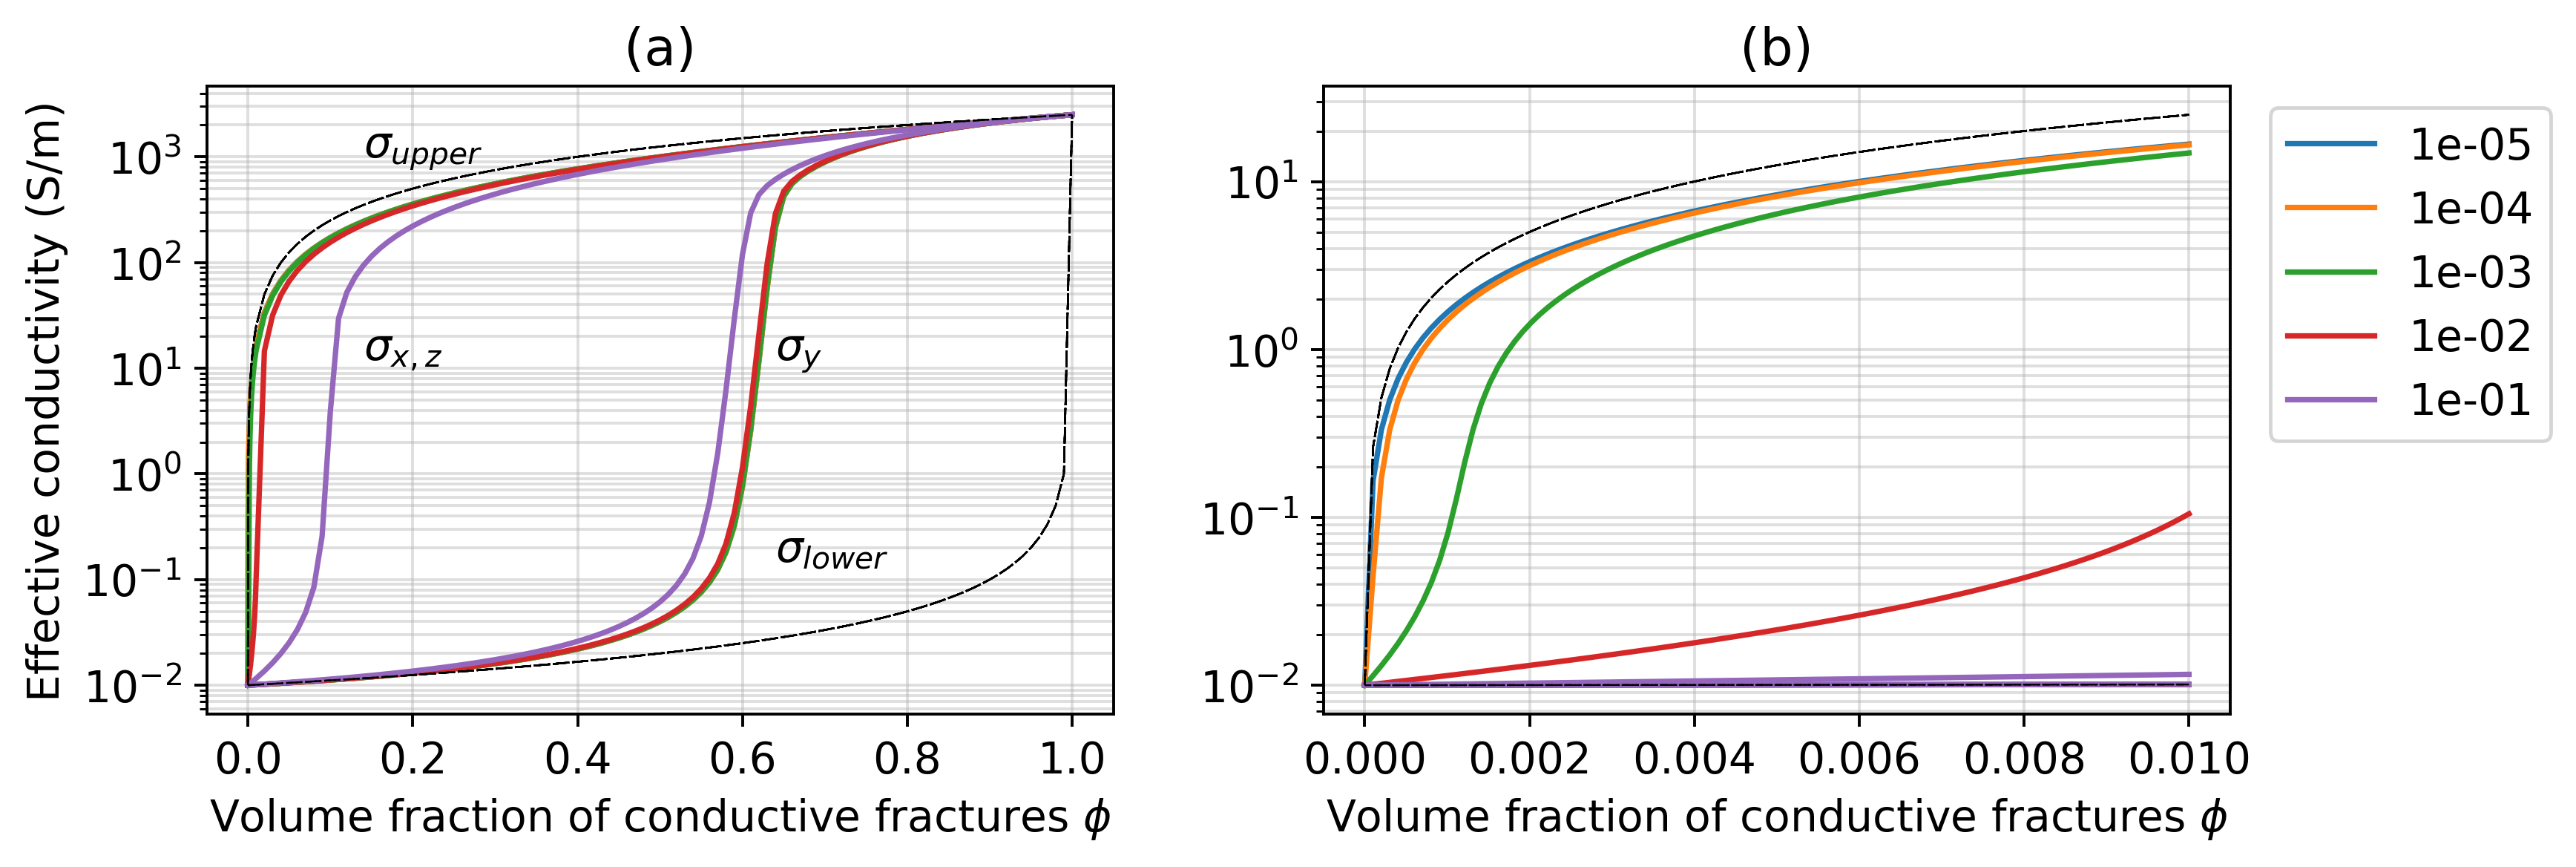

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), dpi=350)

for i, a in enumerate(ax):
    for j, alp in enumerate(alphas[:-1]):
        if i == 0: 
            inds = np.ones(len(phi), dtype=bool)
        elif i == 1: 
            inds = phi <= phi_frac
        
        a.semilogy(phi[inds], sx[inds, j], "C{}".format(j), label="{:1.0e}".format(alp))
        a.semilogy(phi[inds], sy[inds, j], "C{}".format(j))
        a.semilogy(phi[inds], wl[inds, 0], 'k--', lw=0.5)
        a.semilogy(phi[inds], wu[inds, 0], 'k--', lw=0.5)
        a.semilogy(phi[inds], hl[inds, 0], 'k-.', lw=0.5)
        a.semilogy(phi[inds], hu[inds, 0], 'k-.', lw=0.5)
        
    a.grid(which="both", alpha=0.4)

    a.set_xlabel('Volume fraction of conductive fractures $\phi$')
    a.set_title("({})".format(ascii_lowercase[i]))

ax[0].set_ylabel('Effective conductivity (S/m)')

ax[0].annotate("$\sigma_{upper}$", (0.14, 1000))
ax[0].annotate("$\sigma_{lower}$", (0.64, 1.5e-1))

ax[0].annotate("$\sigma_{x, z}$", (0.14, 12))
ax[0].annotate("$\sigma_{y}$", (0.64, 12))


ax[1].legend(bbox_to_anchor=[1.02, 1.])

plt.tight_layout()

fig.savefig("figures/aligned_fractures", dpi=350, bbox_inches="tight")

In [19]:
se = np.zeros((len(phi), len(alphas)))
wl = np.zeros((len(phi), len(alphas)))
wu = np.zeros((len(phi), len(alphas)))
hl = np.zeros((len(phi), len(alphas)))
hu = np.zeros((len(phi), len(alphas)))

for j, a in enumerate(alphas):
    scemt.alpha1 = a
    for i, p in enumerate(phi):
        s = scemt._sc2phaseEMTRandSpheroidstransform(p)
        w = scemt.wenner_bounds(p)
        h = scemt.hashin_shtrikman_bounds(p)
        
        se[i, j] = s
        
        wl[i, j] = w[0]
        wu[i, j] = w[1]
        
        hl[i, j] = h[0]
        hu[i, j] = h[1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:224: UserWarning: Maximum number of iterations reached


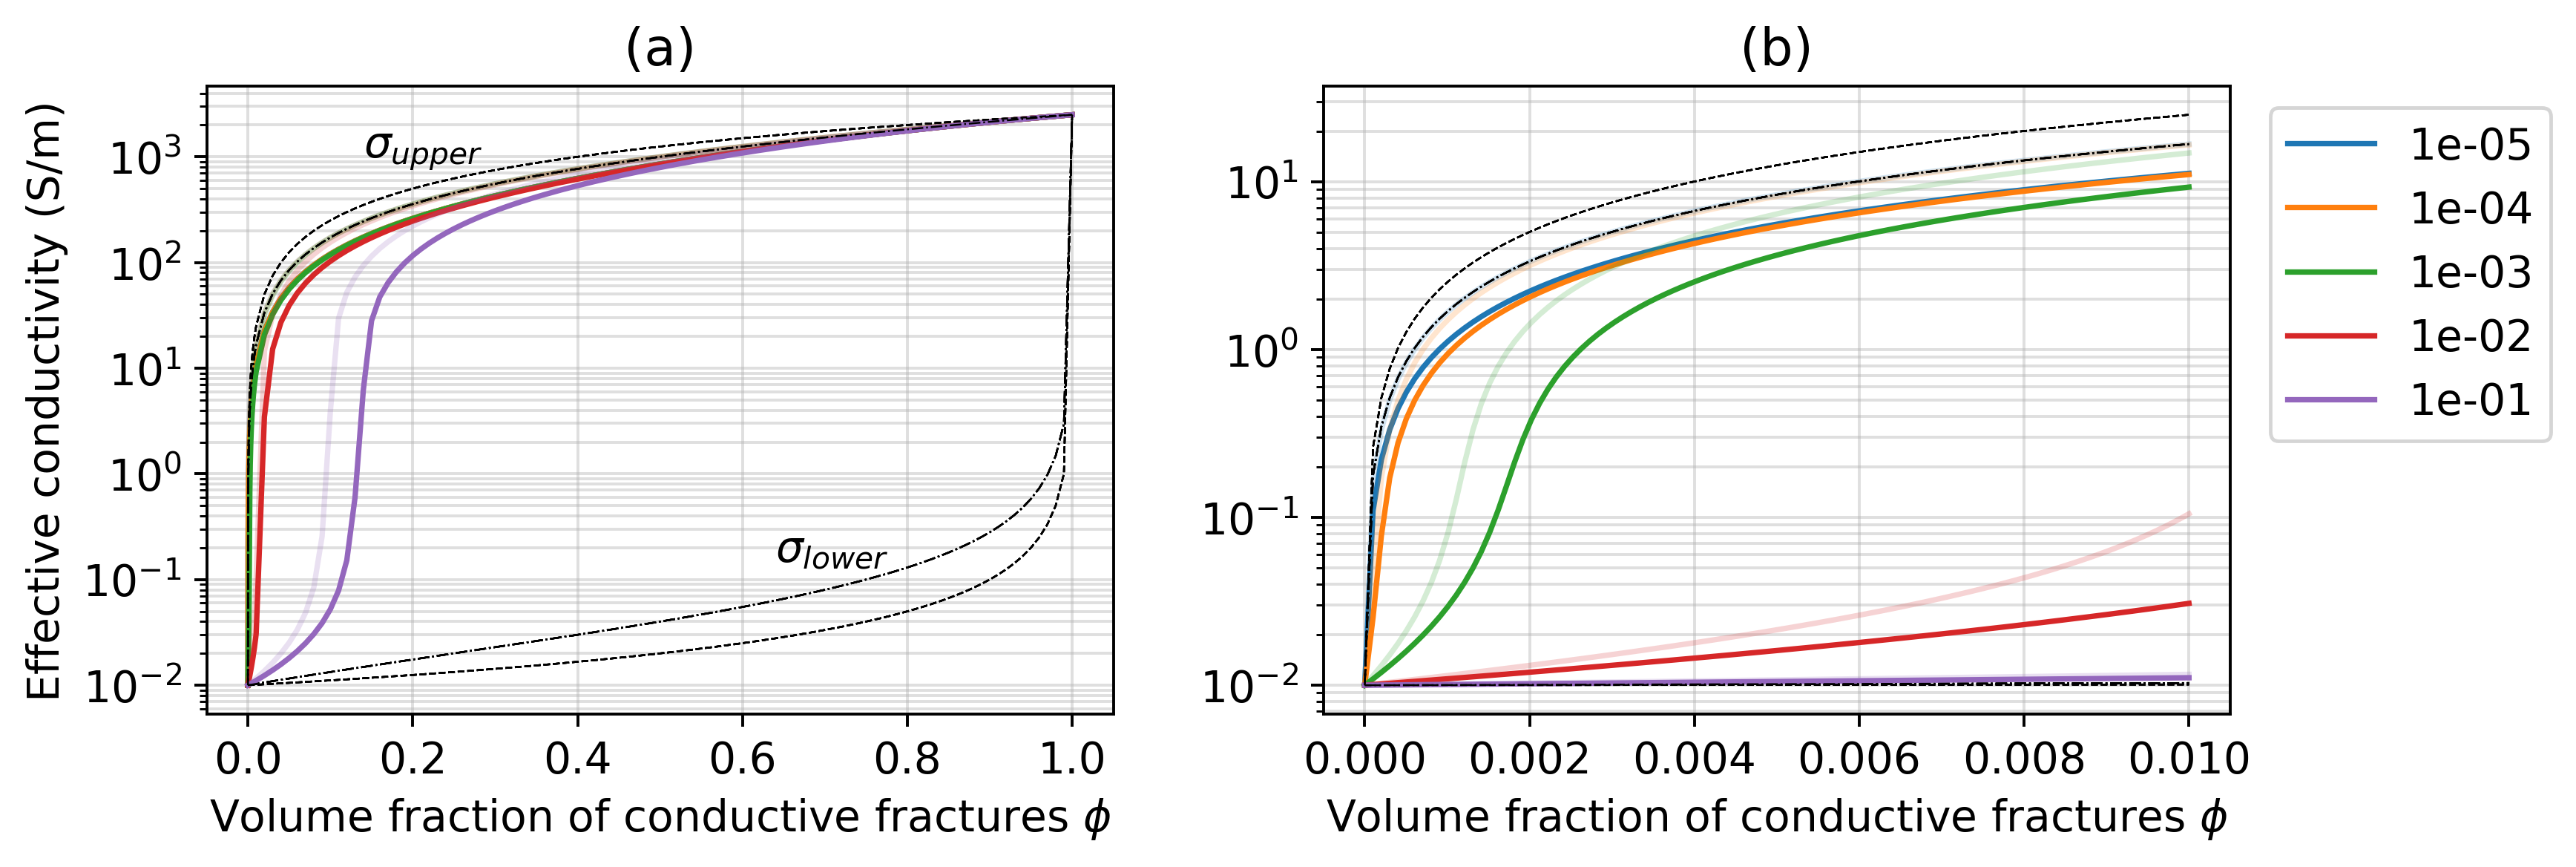

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), dpi=350)

for i, a in enumerate(ax):
    for j, alp in enumerate(alphas[:-1]):
        if i == 0: 
            inds = np.ones(len(phi), dtype=bool)
        elif i == 1: 
            inds = phi <= phi_frac
        
        a.semilogy(phi[inds], sx[inds, j], "C{}".format(j), alpha=0.2)
        a.semilogy(phi[inds], se[inds, j], "C{}".format(j), label="{:1.0e}".format(alp))
        a.semilogy(phi[inds], wl[inds, 0], 'k--', lw=0.5)
        a.semilogy(phi[inds], wu[inds, 0], 'k--', lw=0.5)
        a.semilogy(phi[inds], hl[inds, 0], 'k-.', lw=0.5)
        a.semilogy(phi[inds], hu[inds, 0], 'k-.', lw=0.5)
        
    a.grid(which="both", alpha=0.4)

    a.set_xlabel('Volume fraction of conductive fractures $\phi$')
    a.set_title("({})".format(ascii_lowercase[i]))

ax[0].set_ylabel('Effective conductivity (S/m)')

ax[0].annotate("$\sigma_{upper}$", (0.14, 1000))
ax[0].annotate("$\sigma_{lower}$", (0.64, 1.5e-1))


ax[1].legend(bbox_to_anchor=[1.02, 1.])

plt.tight_layout()

fig.savefig("figures/random_fractures", dpi=350, bbox_inches="tight")

In [21]:
i = 30
phi[i]

0.0030303030303030303

In [22]:
sx[i, 0]

5.05106919969658

In [23]:
sy[i, 0]

0.01003045720972941

In [24]:
se[i, 0]

3.370427750116012